In [156]:
#!pip install scanpy
#!pip install pybiomart
#!pip install scrublet
#!pip3 install leidenalg

## Bring In Sample Data

In [157]:
#!mkdir -p demodata

This notebook is written based on a set of Bone Marrow Cell Data downloaded from Terra.

To copy the data from the Google Cloud, add the Google SDK toolkit to your bash.

In [158]:
#!gsutil -m cp -r gs://terra-featured-workspaces/Cumulus/cellranger_output ./demodata

In [159]:
import os
import numpy as np
import pandas as pd
import scanpy as sc


sc.settings.verbosity = 1
sc.settings.figdir = './figures/'
h5 = './demodata/cellranger_output/'
hdaf5 = './output/'

sc.settings.set_figure_params(dpi=100, fontsize=10, dpi_save=100,
    facecolor = 'white', figsize=(6,6), format='png')

In [160]:
samplenames = sorted(os.listdir(h5))

samplenames


['MantonBM1_HiSeq_1',
 'MantonBM2_HiSeq_1',
 'MantonBM3_HiSeq_1',
 'MantonBM4_HiSeq_1',
 'MantonBM5_HiSeq_1',
 'MantonBM6_HiSeq_1',
 'MantonBM7_HiSeq_1',
 'MantonBM8_HiSeq_1']

In [161]:
filelist = [h5 + s + '/raw_feature_bc_matrix.h5' for s in samplenames]
#len(filelist)

filelist

['./demodata/cellranger_output/MantonBM1_HiSeq_1/raw_feature_bc_matrix.h5',
 './demodata/cellranger_output/MantonBM2_HiSeq_1/raw_feature_bc_matrix.h5',
 './demodata/cellranger_output/MantonBM3_HiSeq_1/raw_feature_bc_matrix.h5',
 './demodata/cellranger_output/MantonBM4_HiSeq_1/raw_feature_bc_matrix.h5',
 './demodata/cellranger_output/MantonBM5_HiSeq_1/raw_feature_bc_matrix.h5',
 './demodata/cellranger_output/MantonBM6_HiSeq_1/raw_feature_bc_matrix.h5',
 './demodata/cellranger_output/MantonBM7_HiSeq_1/raw_feature_bc_matrix.h5',
 './demodata/cellranger_output/MantonBM8_HiSeq_1/raw_feature_bc_matrix.h5']

In [162]:
def read_h5(file):
    if file.endswith('.h5') :
       print ('File type .h5 confirmed')
    else:
        raise ValueError(f'Unsupported filetype: {file}')
    return 
              
for i in range (len(filelist)):
    read_h5(filelist[i])


File type .h5 confirmed
File type .h5 confirmed
File type .h5 confirmed
File type .h5 confirmed
File type .h5 confirmed
File type .h5 confirmed
File type .h5 confirmed
File type .h5 confirmed


In [163]:
metadata_type = ['Female','Male','Male','Male','Male','Female','Female','Female']
samplebrief = [i.split('_', 1)[0] for i in samplenames]
metadata_sample = [i + '_' + j for i, j in zip(samplebrief, metadata_type)]

adatas = [] 
for i in range(len(samplenames)):
    meta = metadata_type[i]
    label = metadata_sample[i]
    filename = filelist[i]
#    print(meta)
#    print(label)
#    print (filename)
#for filename in filelist:
    adata = sc.read_10x_h5(filename)
    adata.var_names_make_unique()
    adata.obs['type'] = meta
    adata.obs['sample'] = label
    adatas.append(adata) 
#    print (adata.obs['type'])
#    print (adata.obs['sample'])

adata = adatas[0].concatenate(adatas[1:])

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


## Print the Number of Observations Per Sample

In [164]:
print(adata.obs['sample'].value_counts())

#adata

MantonBM5_Male      340364
MantonBM6_Female    323253
MantonBM8_Female    308058
MantonBM7_Female    307232
MantonBM1_Female    302618
MantonBM2_Male      281141
MantonBM4_Male      280951
MantonBM3_Male      270127
Name: sample, dtype: int64


## Filter Cells and Genes

* Remove Cells that have Have Gene Expression levels below 500 and above 6000
* Remove Genes that are in less thatn 5% of the Cells



TODO: Filter out genes expressed in less than 5% of the cellls

In [165]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
adata.var

,gene_ids,feature_types,genome,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,4,1.657177e-06,99.999834,4.0
FAM138A,ENSG00000237613,Gene Expression,GRCh38,0,0.000000e+00,100.000000,0.0
OR4F5,ENSG00000186092,Gene Expression,GRCh38,0,0.000000e+00,100.000000,0.0
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,42,1.740035e-05,99.998260,42.0
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,0,0.000000e+00,100.000000,0.0
...,...,...,...,...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,GRCh38,1,4.142941e-07,99.999959,1.0
AC023491.2,ENSG00000278633,Gene Expression,GRCh38,0,0.000000e+00,100.000000,0.0
AC007325.1,ENSG00000276017,Gene Expression,GRCh38,0,0.000000e+00,100.000000,0.0
AC007325.4,ENSG00000278817,Gene Expression,GRCh38,548,2.386334e-04,99.977297,576.0


In [166]:
min_genes = 200
min_counts= 500
min_cells = 10
max_genes = 2000
max_counts = 6000
max_mito = 0.10

#sc.pp.filter_cells(adata, min_genes=200)

#sc.pp.filter_genes(adata, min_cells=)

sc.pp.filter_cells(adata, min_genes=min_genes)
sc.pp.filter_cells(adata, min_counts=min_counts)
sc.pp.filter_cells(adata, max_counts=max_counts)
sc.pp.filter_genes(adata, min_cells=min_cells)


print(adata.obs['sample'].value_counts())

MantonBM6_Female    5524
MantonBM7_Female    5374
MantonBM8_Female    5307
MantonBM2_Male      5224
MantonBM4_Male      5040
MantonBM1_Female    4951
MantonBM3_Male      4781
MantonBM5_Male      4524
Name: sample, dtype: int64


In [167]:

toolow = adata.var.n_cells_by_counts.sum()

#adata.var
toolow

72365035

## Find Occurrence of Mitochondrial and Ribosomal Genes

In [168]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.var

,gene_ids,feature_types,genome,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,mt
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,22,0.000540,99.945979,22.0,22,False
AL627309.5,ENSG00000241860,Gene Expression,GRCh38,101,0.002480,99.751995,101.0,101,False
LINC01409,ENSG00000237491,Gene Expression,GRCh38,1530,0.040614,96.243094,1654.0,1530,False
LINC01128,ENSG00000228794,Gene Expression,GRCh38,850,0.021780,97.912830,887.0,850,False
LINC00115,ENSG00000225880,Gene Expression,GRCh38,176,0.004420,99.567833,180.0,176,False
...,...,...,...,...,...,...,...,...,...
AL354822.1,ENSG00000278384,Gene Expression,GRCh38,56,0.001400,99.862492,57.0,56,False
AL592183.1,ENSG00000273748,Gene Expression,GRCh38,2487,0.065611,93.893186,2672.0,2487,False
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,231,0.005746,99.432781,234.0,231,False
AC004556.3,ENSG00000276345,Gene Expression,GRCh38,142,0.003511,99.651320,143.0,142,False


In [169]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

adata.var

,gene_ids,feature_types,genome,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,mt,ribo,hb
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,22,0.000540,99.945979,22.0,22,False,False,False
AL627309.5,ENSG00000241860,Gene Expression,GRCh38,101,0.002480,99.751995,101.0,101,False,False,False
LINC01409,ENSG00000237491,Gene Expression,GRCh38,1530,0.040614,96.243094,1654.0,1530,False,False,False
LINC01128,ENSG00000228794,Gene Expression,GRCh38,850,0.021780,97.912830,887.0,850,False,False,False
LINC00115,ENSG00000225880,Gene Expression,GRCh38,176,0.004420,99.567833,180.0,176,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
AL354822.1,ENSG00000278384,Gene Expression,GRCh38,56,0.001400,99.862492,57.0,56,False,False,False
AL592183.1,ENSG00000273748,Gene Expression,GRCh38,2487,0.065611,93.893186,2672.0,2487,False,False,False
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,231,0.005746,99.432781,234.0,231,False,False,False
AC004556.3,ENSG00000276345,Gene Expression,GRCh38,142,0.003511,99.651320,143.0,142,False,False,False


In [170]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [171]:
# filter for gene detection
#keep = (adata.obs['n_genes_by_counts'] < 6000) & (adata.obs['n_genes_by_counts'] > 500)

#print(sum(keep))
#adata = adata[keep, :]

#print("Remaining cells %d"%adata.n_obs)

In [172]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
np.seterr(invalid='ignore')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

Uncomment this cell to see the jitter plots for the samples.

In [173]:
#sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="sample")

In [174]:
#sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
 #            jitter=0.4, groupby = 'sample', rotation= 45,show=True)

#plt.savefig("demodata/mito_counts_violin.pdf")


In [175]:
# filter for percent mito

adata = adata[adata.obs['pct_counts_mt'] < 10, :]

# filter for percent ribo > 0.05
adata = adata[adata.obs['pct_counts_ribo'] > 5, :]

print("Remaining cells %d"%adata.n_obs)

Remaining cells 38388


In [176]:
#sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
 #            jitter=0.4, groupby = 'sample', rotation = 45)

## Filter out Technical Artifacts

In [177]:
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith('MT-')
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

remove = np.add(mito_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

38388 22722


In [178]:
#sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
  #           jitter=0.4, groupby = 'sample', rotation = 45)

/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


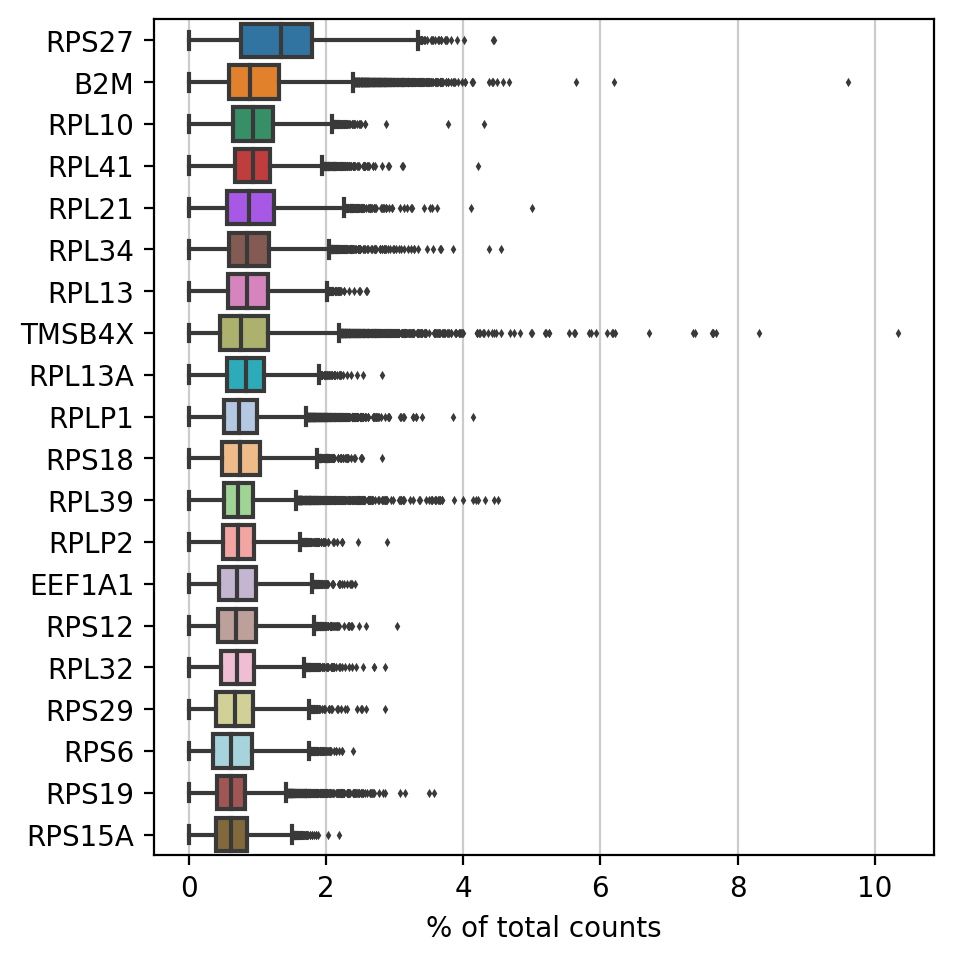

In [179]:
sc.pl.highest_expr_genes(adata, n_top=20)

## This section is optional 

This section looks at chrY markers and determines the likelihood of the gender of the sample origin.

This is the source of the metadata at the top of the notebook.

In [180]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")
#>>> adata.var[annot.columns] = annot

In [181]:
chrY_genes = adata.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['RPS4Y1', 'ZFY', 'ZFY-AS1', 'LINC00278', 'PCDH11Y', 'PRKY', 'USP9Y',
       'DDX3Y', 'UTY', 'TMSB4Y', 'NLGN4Y', 'TTTY14', 'KDM5D', 'TTTY10',
       'EIF1AY', 'RPS4Y2'],
      dtype='object')

In [182]:
adata.obs['percent_chrY'] = np.sum(
    adata[:, chrY_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1 * 100

In [183]:
# color inputs must be from either .obs or .var, so add in XIST expression to obs.
adata.obs["XIST-counts"] = adata.X[:,adata.var_names.str.match('XIST')].toarray()

#sc.pl.scatter(adata, x='XIST-counts', y='percent_chrY', color="sample")

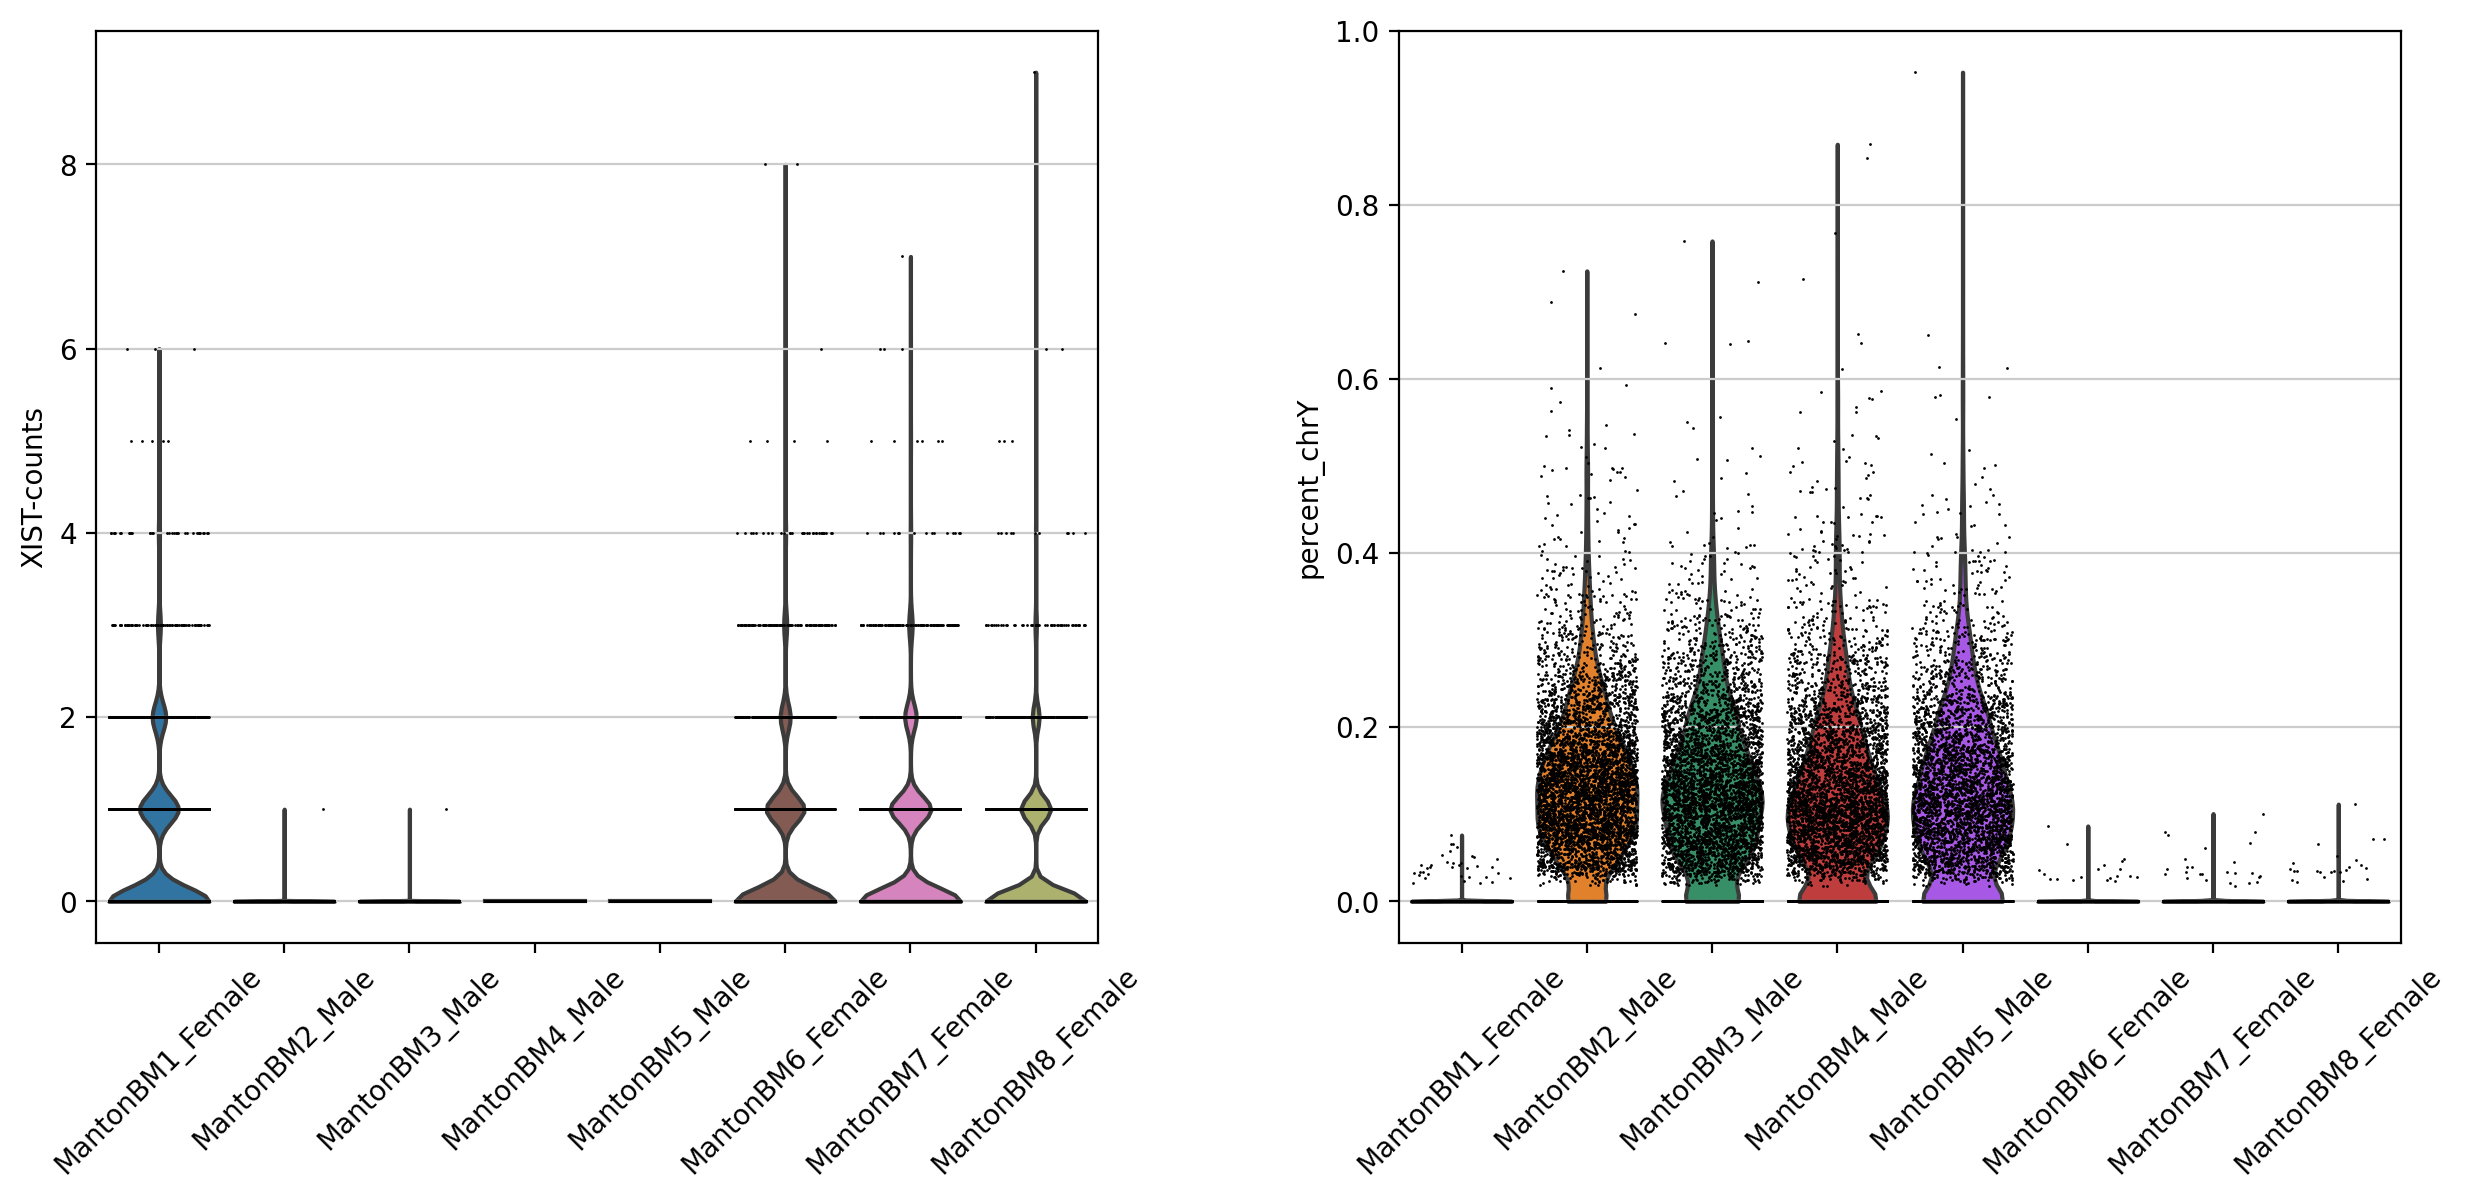

In [184]:

import matplotlib.pyplot as plt

sc.pl.violin(adata, ["XIST-counts", "percent_chrY"], jitter=0.4, groupby = 'sample', rotation= 45,show=False)

plt.savefig("demodata/gender_counts_violin.pdf")




## Cell Cycle Genes and extract Highly Expressed Genes

In [185]:
!if [ ! -f data/regev_lab_cell_cycle_genes.txt ]; \
then curl -o data/regev_lab_cell_cycle_genes.txt \
https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt;\
fi
    

In [186]:
cell_cycle_genes = [x.strip() for x in open('./data/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

97
94


### Log Normalize Data by 100,000 Reads Per Cell

In [187]:
sc.pp.filter_genes(adata, min_cells=1)
sc.pp.normalize_total(adata, target_sum=1e5)
sc.pp.log1p(adata)

print(adata.n_obs, adata.n_vars)

38388 22722


In [188]:
print(adata.n_obs, adata.n_vars)

38388 22722


In [189]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

In [190]:
#sc.pl.violin(adata, ['S_score', 'G2M_score'],
#             jitter=0.4, groupby = 'sample', rotation=45)

### Optional Demo on Doublets

In [191]:
#import scrublet as scr

# split per batch into new objects.
#batches = adata.obs['sample'].cat.categories.tolist()
#alldata = {}
#for batch in batches:
#    tmp = adata[adata.obs['sample'] == batch,]
#    print(batch, ":", tmp.shape[0], " cells")
#    scrub = scr.Scrublet(tmp.raw.X)
#    out = scrub.scrub_doublets(verbose=False, n_prin_comps = 20)
#    alldata[batch] = pd.DataFrame({'doublet_score':out[0],'predicted_doublets':out[1]},index = tmp.obs.index)
#    print(alldata[batch].predicted_doublets.sum(), " predicted_doublets")

In [192]:
# add predictions to the adata object.
#scrub_pred = pd.concat(alldata.values())
#adata.obs['doublet_scores'] = scrub_pred['doublet_score'] 
#adata.obs['predicted_doublets'] = scrub_pred['predicted_doublets'] 

#sum(adata.obs['predicted_doublets'])

In [193]:
# add in column with singlet/doublet instead of True/Fals
#%matplotlib inline

#adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

#sc.pl.violin(adata, 'n_genes_by_counts',
#             jitter=0.4, groupby = 'doublet_info', rotation=45)

In [194]:
#sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
#sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [195]:
## Extract Highly Variable Genes

In [196]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

adata.var.highly_variable

HES4          True
ISG15         True
ANKRD65       True
AL691432.4    True
CFAP74        True
              ... 
TTTY14        True
EIF1AY        True
RPS4Y2        True
AL354822.1    True
AC007325.4    True
Name: highly_variable, Length: 3927, dtype: bool

TODO: Select the top 2000 genes

In [197]:
#sc.pl.highly_variable_genes(adata)

In [198]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [199]:
sc.pp.scale(adata, max_value=10)

## Run PCA

In [200]:
sc.tl.pca(adata, svd_solver='arpack')

## Run Nearest Neighbor Analysis

In [201]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

## Run UMAP Data

In [ ]:
#sc.tl.paga(adata)
#sc.pl.paga(adata, plot=True)  # remove `plot=False` if you want to see the coarse-grained graph
#sc.tl.umap(adata, init_pos='paga')
sc.tl.umap(adata)

In [ ]:
#sc.pl.pca(adata, color='RPL10') #Note need to find a gene name for the BM samples

In [ ]:
#sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

## Run Leiden Analysis

In [ ]:
sc.tl.leiden(adata)

## Test Color by Leiden on UMAP

In [ ]:
sc.pl.umap(adata, color=['leiden'])

In [ ]:
!mkdir -p results

results_file = 'results/combined_MantonBM.h5ad'
adata.write(results_file)

In [ ]:
#sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
#sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
dedf = sc.get.rank_genes_groups_df(adata, group="0")
dedfup = dedf.head(20)
dedfdown = dedf.tail(20)
dedfup.names

TODO: Send each channel to it's own file and own plot